In [1]:
!pip install fasttext --quiet
import os
import joblib
import fasttext.util
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
fasttext.util.download_model('pl', if_exists='ignore')

'cc.pl.300.bin'

In [3]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [4]:
def get_ft_vector(text):
    cleaned_text = str(text).replace('\n', ' ').strip()
    return ft_model.get_sentence_vector(cleaned_text)

In [5]:
def load_and_embed(file_path):
    df = pd.read_csv(file_path)
    X = np.vstack(df['Text'].apply(get_ft_vector))
    y = df['Class'].values
    return X, y

In [ ]:
def train_evaluate(X, y, param_grid, title="Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print(f"\n📌 {title} – Najlepsze parametry:")
    print(grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📊 Wyniki ({title}):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("\nConfusion Matrix:\n", cm)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    save_dir = f"{title}_results"
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for RF - The Best Varian")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{title}_confusion_matrix.png"))
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for RF - The Best Varian")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{title}_roc_curve.png"))
    plt.show()

    model_path = os.path.join(save_dir, f"{title}.joblib")
    joblib.dump(best_model, model_path)
    print(f"✅ Model zapisany do: {model_path}")

In [7]:
X_raw, y_raw = load_and_embed('BAN-PL_raw.csv')
X_pre, y_pre = load_and_embed('BAN-PL_light.csv')
X_full, y_full = load_and_embed('BAN-PL_full.csv')

In [ ]:
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt'],
    'class_weight': [None]
}

Fitting 4 folds for each of 16 candidates, totalling 64 fits

📌 RF - Raw data – Najlepsze parametry:
{'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8024

📊 Wyniki (RF - Raw data):
Accuracy:  0.8027
Precision: 0.8130
Recall:    0.7863
F1-score:  0.7994
ROC AUC:   0.8851

Confusion Matrix:
 [[1966  434]
 [ 513 1887]]

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2400
           1       0.81      0.79      0.80      2400

    accuracy                           0.80      4800
   macro avg       0.80      0.80      0.80      4800
weighted avg       0.80      0.80      0.80      4800



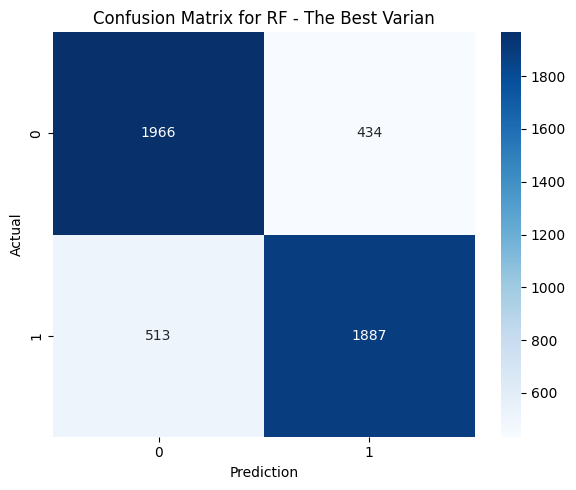

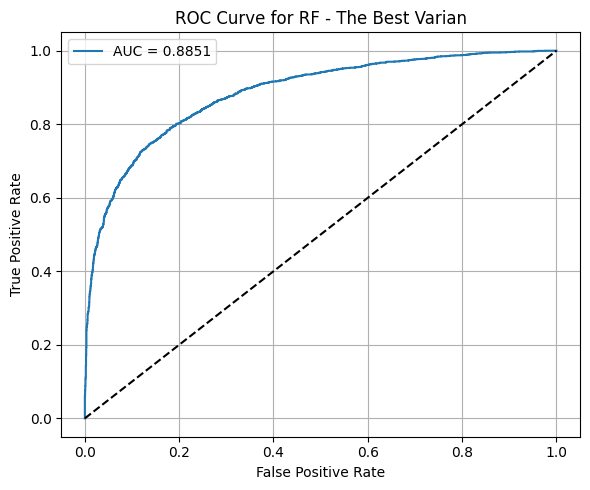

✅ Model zapisany do: RF - Raw data_results/RF - Raw data.joblib


In [9]:
train_evaluate(X_raw, y_raw, param_grid, title="RF - Raw data")

Fitting 4 folds for each of 16 candidates, totalling 64 fits

📌 RF - Preprocessed data – Najlepsze parametry:
{'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7950

📊 Wyniki (RF - Preprocessed data):
Accuracy:  0.8052
Precision: 0.8143
Recall:    0.7905
F1-score:  0.8022
ROC AUC:   0.8798

Confusion Matrix:
 [[1967  432]
 [ 502 1894]]

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2399
           1       0.81      0.79      0.80      2396

    accuracy                           0.81      4795
   macro avg       0.81      0.81      0.81      4795
weighted avg       0.81      0.81      0.81      4795



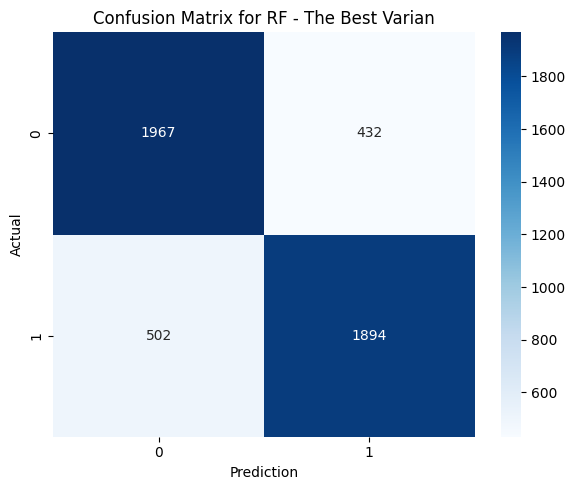

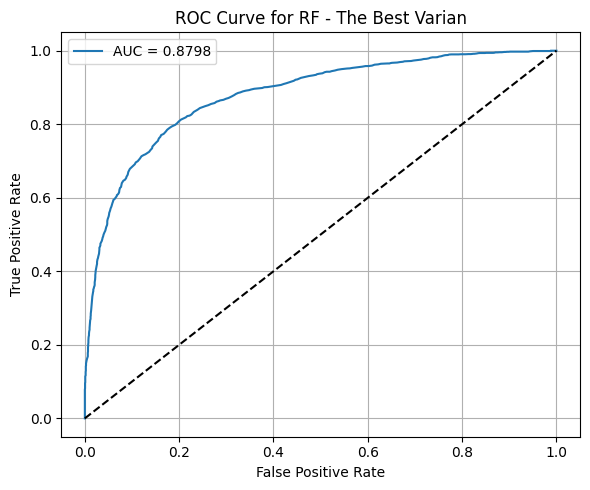

✅ Model zapisany do: RF - Preprocessed data_results/RF - Preprocessed data.joblib


In [10]:
train_evaluate(X_pre, y_pre, param_grid, title="RF - Preprocessed data")

Fitting 4 folds for each of 16 candidates, totalling 64 fits

📌 RF - Fully processed data – Najlepsze parametry:
{'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8100

📊 Wyniki (RF - Fully processed data):
Accuracy:  0.8140
Precision: 0.8437
Recall:    0.7711
F1-score:  0.8058
ROC AUC:   0.8900

Confusion Matrix:
 [[2049  342]
 [ 548 1846]]

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2391
           1       0.84      0.77      0.81      2394

    accuracy                           0.81      4785
   macro avg       0.82      0.81      0.81      4785
weighted avg       0.82      0.81      0.81      4785



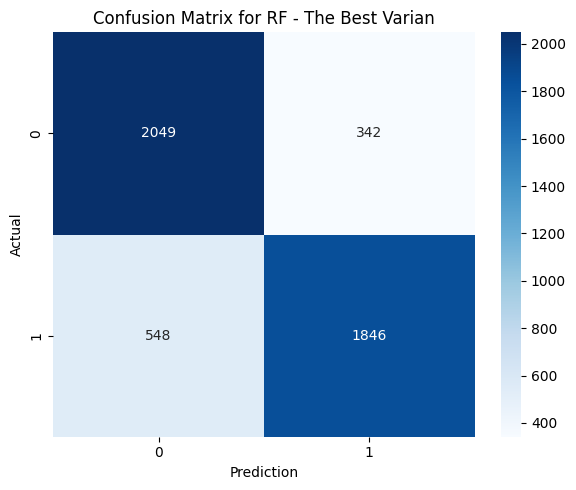

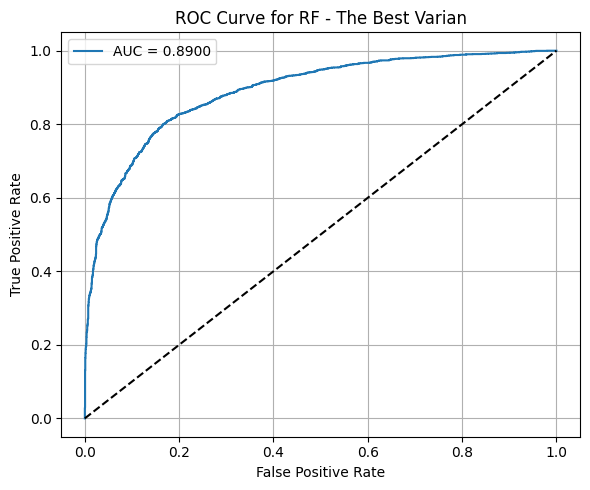

✅ Model zapisany do: RF - Fully processed data_results/RF - Fully processed data.joblib


In [11]:
train_evaluate(X_full, y_full, param_grid, title="RF - Fully processed data")